In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import numpy as np
import warnings

## Obtener datos

### Gastos

In [102]:
tipos_de_gastos_files_xls = [
    "data/input/gastos/alcaldia-tipos_de_gastos__alcaldia___2024-03-09T02_06_53.838153Z.xlsx",
    "data/input/gastos/gobernacion-tipos_de_gastos__2024-03-09T02_00_59.376388Z.xlsx",
]


gastos_df = pd.DataFrame()

for f in tipos_de_gastos_files_xls:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df_temp = pd.read_excel(f, engine="openpyxl")

    gastos_df = pd.concat([gastos_df, df_temp], ignore_index=True)

## Renombrar las columnas
gastos_df = gastos_df.rename(
    columns={
        "Corporaciones - ID Corporacion → Nombre": "Cargo",
        "Formato Ingresos Gastos - ID Formato Ingresos Gasto → Codigo": "Gasto Id",
        "Candidatos → Sexo": "Sexo",
        "Candidatos → Etnia": "Etnia",
        "Departamentos - ID Departamento → Nombre": "Departamento",
        "Ciudades → Nombre": "Ciudades",
        "Agrupaciones Politicas → Nombre": "Agrupacion Politica",
        "Coalicion Politica → Nombre": "Coalicion Politica",
        "Grupos Significativos → Nombre": "Grupo Politico",
        "Suma de Gastos → Total": "Total",
    }
)



### Ingresos

In [103]:
tipos_de_ingresos_files_xls = [
    "data/input/ingresos/alcaldia_tipo_de_ingresos.xlsx",
    "data/input/ingresos/gobernacion_tipo_de_ingresos.xlsx",
]


ingresos_df = pd.DataFrame()

## Concatenar los dos archivos
for f in tipos_de_ingresos_files_xls:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df_temp = pd.read_excel(f, engine="openpyxl")

    ingresos_df = pd.concat([ingresos_df, df_temp], ignore_index=True)
    

## Renombrar las columnas
ingresos_df = ingresos_df.rename(
    columns={
        "Corporaciones - ID Corporacion → Nombre": "Cargo",
        "Formato Ingresos Gastos - ID Formato Ingresos Gasto → Codigo": "Gasto Id",
        "Candidatos → Sexo": "Sexo",
        "Candidatos → Etnia": "Etnia",
        "Departamentos - ID Departamento → Nombre": "Departamento",
        "Ciudades → Nombre": "Ciudades",
        "Agrupaciones Politicas → Nombre": "Agrupacion Politica",
        "Coalicion Politica → Nombre": "Coalicion Politica",
        "Grupos Significativos → Nombre": "Grupo Politico",
        "Suma de Ingresos → Total": "Total",
        "Codigo pro":"Codigo Pro"
    }
)
    
ingresos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8712 entries, 0 to 8711
Data columns (total 18 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Nombre                                                        8712 non-null   object 
 1   Apellido                                                      8712 non-null   object 
 2   Cargo                                                         8712 non-null   object 
 3   Gasto Id                                                      8712 non-null   int64  
 4   Sexo                                                          8710 non-null   object 
 5   Etnia                                                         4281 non-null   float64
 6   Departamento                                                  8712 non-null   object 
 7   Ciudades                                                      8235 no

# Pre-Procesamiento

## Convertir tres columnas con valores únicos a dos columnas con tipo y valor

In [104]:
columnas_originales = [
    "Agrupacion Politica",
    "Coalicion Politica",
    "Grupo Politico",
]


def categorizar(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]
    if isinstance(aggPolitica, str):
        return "Agrupacion Politica"
    if isinstance(coalicionPolitica, str):
        return "Coalicion Politica"
    if isinstance(grupoPolitico, str):
        return "Grupo Politico"


def categorizarConNombre(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]

    if isinstance(aggPolitica, str):
        return aggPolitica
    if isinstance(coalicionPolitica, str):
        return coalicionPolitica
    if isinstance(grupoPolitico, str):
        return grupoPolitico


### Gastos

In [105]:


gastos_df["Tipo de Agrupación"] = gastos_df.apply(categorizar, axis=1)
gastos_df["Nombre de Agrupación"] = gastos_df.apply(categorizarConNombre, axis=1)

gastos_df = gastos_df.drop(columns=columnas_originales)
gastos_df.head()

,Nombre,Apellido,Cargo,Gasto Id,Sexo,Etnia,Departamento,Ciudades,Total,Contar,Etnias,Género,Codigo Pro,Tipo de Agrupación,Nombre de Agrupación
0,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,205,M,NaN,Antioquia,San Rafael,10400000.0,3,NaN,Masculino,205 - Servicio de transporte y correo,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
1,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,207,M,NaN,Antioquia,San Rafael,200000.0,1,NaN,Masculino,207 - Gastos judiciales y de rendición de cuentas,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
2,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,208,M,NaN,Antioquia,San Rafael,6030000.0,1,NaN,Masculino,208 - Gastos de propaganda electoral,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
3,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,211,M,NaN,Antioquia,San Rafael,1570000.0,1,NaN,Masculino,211 - Otros gastos,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
4,ABEL ALBERTO,POLANCO LEMOS,Alcaldia_fun,203,M,NaN,Bolívar,Tiquisio,3000000.0,1,NaN,Masculino,203 - Inversión en materiales y publicaciones,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO


### Ingresos

In [106]:
ingresos_df["Tipo de Agrupación"] = ingresos_df.apply(categorizar, axis=1)
ingresos_df["Nombre de Agrupación"] = ingresos_df.apply(categorizarConNombre, axis=1)

ingresos_df = ingresos_df.drop(columns=columnas_originales)



### Funciones generales

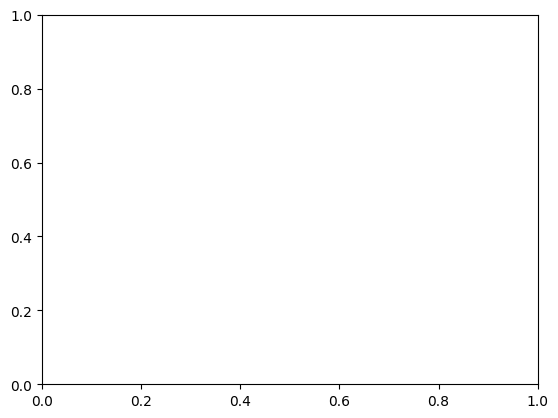

In [172]:

def millions_billions_formatter(x, pos):
    if x >= 1e9:
        return f"{x / 1e9:.0f}B"
    elif x >= 1e6:
        return f"{x / 1e6:.0f}M"
    else:
        return f"{x:.0f}"


func_form_millon_billon = FuncFormatter(millions_billions_formatter)
def truncate_label(label, length=20):
    if len(label) > length:
        return label[: length - 3] + "..."
    else:
        return label


format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]


def autoLabel():
    for bar in plt.gca().patches:
        height = bar.get_height()

        formatted_height = millions_billions_formatter(height, None)
        plt.gca().annotate(
            formatted_height,
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # Desplazamiento vertical del texto
            textcoords="offset points",
            ha="center",
            va="bottom",
        )
def autoLabelY():
    for bar in plt.gca().patches:
        width = bar.get_width()
        formatted_width = millions_billions_formatter(width, None)
        plt.gca().annotate(
            formatted_width,
            xy=(width, bar.get_y() + bar.get_height() / 2),
            xytext=(3, 0),  # Desplazamiento horizontal del texto
            textcoords="offset points",
            ha="left",
            va="center",
        )


## Concatenar nombre y apellidos

### Gastos

In [108]:
gastos_df['Nombre'] = gastos_df['Nombre'].str.strip().str.lower().str.replace(' ', '_') + '_' + gastos_df['Apellido'].str.strip().str.lower().str.replace(' ', '_')
gastos_df.drop(columns=["Apellido","Género","Etnia","Etnias"], axis=2,inplace=True)
gastos_df.shape


(24308, 11)

In [109]:
gastos_df["Nombre"].unique().size

5955

In [110]:
gastos_df.columns

Index(['Nombre', 'Cargo', 'Gasto Id', 'Sexo', 'Departamento', 'Ciudades',
       'Total', 'Contar', 'Codigo Pro', 'Tipo de Agrupación',
       'Nombre de Agrupación'],
      dtype='object')

In [111]:
gastos_df.dtypes

Nombre                   object
Cargo                    object
Gasto Id                  int64
Sexo                     object
Departamento             object
Ciudades                 object
Total                   float64
Contar                    int64
Codigo Pro               object
Tipo de Agrupación       object
Nombre de Agrupación     object
dtype: object

### Ingreso

In [112]:

ingresos_df['Nombre'] = ingresos_df['Nombre'].str.strip().str.lower().str.replace(' ', '_') + '_' + ingresos_df['Apellido'].str.strip().str.lower().str.replace(' ', '_')
ingresos_df.drop(columns=["Apellido","Género","Etnia","Etnias"], axis=2,inplace=True)
ingresos_df.shape

(8712, 13)

In [113]:
ingresos_df["Nombre"].unique().size

5961

In [114]:
ingresos_df.columns

Index(['Nombre', 'Cargo', 'Gasto Id', 'Sexo', 'Departamento', 'Ciudades',
       'Total', 'Contar', 'Codigo Pro',
       'Formato Ingresos Gastos - ID Formato Ingresos Gasto → Nombre',
       'Tipos Circunscripcion - ID Circunscripcion → Nombre',
       'Tipo de Agrupación', 'Nombre de Agrupación'],
      dtype='object')

## Normalizar columna Codigo por

### Gastos

In [115]:
gastos_df["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica',
       '211 -\xa0Otros\xa0gastos'], dtype=object)

In [116]:
def normalizeCodigoPro(fila):
    codigo = fila["Codigo Pro"]
    if isinstance(codigo, str):
        if codigo.startswith("211"):
            return codigo.replace("\xa0", " ")
        else:
            return codigo
    else:
        return codigo


gastos_df["Codigo Pro"] = gastos_df.apply(normalizeCodigoPro, axis=1)
gastos_df["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica'],
      dtype=object)

### Ingreso

In [117]:
ingresos_df["Codigo Pro"].unique()

array(['101 - Recursos propios y familiares',
       '102 - Donaciones de particulares',
       '106 - Recursos de origen privado destinado por los partidos',
       '107 - Rendimientos\xa0financieros',
       '104 - Ingresos de actos públicos del partido',
       '103 - Créditos de entidades financieras',
       '105 - Financiación estatal - Anticipos'], dtype=object)

In [118]:
def normalizeCodigoPro(fila):
    codigo = fila["Codigo Pro"]
    if isinstance(codigo, str):
        if codigo.startswith("107"):
            return codigo.replace("\xa0", " ")
        else:
            return codigo
    else:
        return codigo


ingresos_df["Codigo Pro"] = ingresos_df.apply(normalizeCodigoPro, axis=1)
ingresos_df["Codigo Pro"].unique()

array(['101 - Recursos propios y familiares',
       '102 - Donaciones de particulares',
       '106 - Recursos de origen privado destinado por los partidos',
       '107 - Rendimientos financieros',
       '104 - Ingresos de actos públicos del partido',
       '103 - Créditos de entidades financieras',
       '105 - Financiación estatal - Anticipos'], dtype=object)

## Cada tipo de gasto como columna

### Gastos

In [119]:
gastos_df["Ciudades"].fillna("Desconocido", inplace=True)

gastos_df_i2 = gastos_df.pivot_table(
    index=[
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Contar",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    columns="Codigo Pro",
    values="Total",
    aggfunc="sum",
    # dropna=False,
    # fill_value=0,
)

gastos_df_i2 = gastos_df_i2.reset_index()

gastos_df_i2.columns.name = None


gastos_df_i2 = gastos_df_i2.groupby(
    [
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    as_index=False,
).agg(
    {
        "Contar": "sum",
        "201 - Gastos de Administración": "sum",
        "202 - Gastos de oficina y adquisiciones": "sum",
        "203 - Inversión en materiales y publicaciones": "sum",
        "204 - Actos públicos": "sum",
        "205 - Servicio de transporte y correo": "sum",
        "206 - Gastos de capacitación e investigación politica": "sum",
        "207 - Gastos judiciales y de rendición de cuentas": "sum",
        "208 - Gastos de propaganda electoral": "sum",
        "209 - Costos financieros": "sum",
        "211 - Otros gastos": "sum",
    }
)
gastos_df_i2.shape

(5916, 18)

In [120]:
gastos_df_i2["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica'],
      dtype=object)

In [122]:
duplicated_names = gastos_df_i2[gastos_df_i2.duplicated('Nombre', keep=False)]
duplicated_names

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar,201 - Gastos de Administración,202 - Gastos de oficina y adquisiciones,203 - Inversión en materiales y publicaciones,204 - Actos públicos,205 - Servicio de transporte y correo,206 - Gastos de capacitación e investigación politica,207 - Gastos judiciales y de rendición de cuentas,208 - Gastos de propaganda electoral,209 - Costos financieros,211 - Otros gastos
649,carlos_andres_osorio_franco,Alcaldia_fun,M,Risaralda,La Virginia,Coalicion Politica,ALIANZA HACIENDO HISTORIA,6,14900000.0,35000.0,363800.0,3804908.0,0.0,0.0,0.0,0.0,0.0,0.0
650,carlos_andres_osorio_franco,Alcaldia_fun,M,Santander,Piedecuesta,Agrupacion Politica,PARTIDO POLITICO CREEMOS,3,0.0,0.0,0.0,0.0,0.0,0.0,700000.0,1785000.0,0.0,0.0
3492,juan_carlos_sarmiento_sarmiento,Alcaldia_fun,M,Boyacá,Cómbita,Coalicion Politica,COMBITA RENACE,18,39133327.0,9100000.0,5047000.0,9800000.0,19037888.0,0.0,1000000.0,16643630.0,0.0,0.0
3493,juan_carlos_sarmiento_sarmiento,Alcaldia_fun,M,Risaralda,Marsella,Agrupacion Politica,MOVIMIENTO POLITICO COLOMBIA HUMANA,11,0.0,0.0,0.0,1014950.0,2400000.0,0.0,2000000.0,17397500.0,89316.0,0.0
4226,marco_aurelio_lopez_gomez,Alcaldia_fun,M,Boyacá,Desconocido,Agrupacion Politica,PARTIDO CENTRO DEMOCRATICO,15,0.0,0.0,0.0,0.0,1222538.0,0.0,250000.0,87860.0,0.0,0.0
4227,marco_aurelio_lopez_gomez,Alcaldia_fun,M,Boyacá,Sativasur,Coalicion Politica,UNIDOS POR SATIVASUR,33,0.0,0.0,0.0,0.0,2624789.0,0.0,300000.0,6902000.0,0.0,0.0
5345,sandra_yanet_montero_lancheros,Alcaldia_fun,F,Cundinamarca,Simijaca,Agrupacion Politica,PARTIDO CONSERVADOR COLOMBIANO,6,0.0,0.0,0.0,1044600.0,0.0,0.0,1000000.0,3794000.0,0.0,0.0
5346,sandra_yanet_montero_lancheros,Alcaldia_fun,F,Cundinamarca,Simijaca,Coalicion Politica,SIMIJACA UNIDA POR LA DEMOCRACIA,3,0.0,0.0,4800000.0,12634000.0,0.0,0.0,100000.0,9785000.0,0.0,0.0


### Ingresos

In [123]:
ingresos_df["Ciudades"].fillna("Desconocido", inplace=True)

ingresos_df_i2 = ingresos_df.pivot_table(
    index=[
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Contar",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    columns="Codigo Pro",
    values="Total",
    aggfunc="sum",
    # dropna=False,
    # fill_value=0,
)

ingresos_df_i2 = ingresos_df_i2.reset_index()

ingresos_df_i2.columns.name = None

ingresos_df_i2 = ingresos_df_i2.groupby(
    [
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    as_index=False,
).agg(
    {
        "Contar": "sum",
        "101 - Recursos propios y familiares": "sum",
        "102 - Donaciones de particulares": "sum",
        "106 - Recursos de origen privado destinado por los partidos": "sum",
        "107 - Rendimientos financieros": "sum",
        "104 - Ingresos de actos públicos del partido": "sum",
        "103 - Créditos de entidades financieras": "sum",
        "105 - Financiación estatal - Anticipos": "sum",
    }
)
ingresos_df_i2.shape

(5921, 15)

In [124]:
duplicated_names = ingresos_df_i2[ingresos_df_i2.duplicated('Nombre', keep=False)]
duplicated_names

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar,101 - Recursos propios y familiares,102 - Donaciones de particulares,106 - Recursos de origen privado destinado por los partidos,107 - Rendimientos financieros,104 - Ingresos de actos públicos del partido,103 - Créditos de entidades financieras,105 - Financiación estatal - Anticipos
649,carlos_andres_osorio_franco,Alcaldia_fun,M,Risaralda,La Virginia,Coalicion Politica,ALIANZA HACIENDO HISTORIA,1,19103708.0,0.0,0.0,0.0,0.0,0.0,0.0
650,carlos_andres_osorio_franco,Alcaldia_fun,M,Santander,Piedecuesta,Agrupacion Politica,PARTIDO POLITICO CREEMOS,2,2485000.0,0.0,0.0,0.0,0.0,0.0,0.0
3499,juan_carlos_sarmiento_sarmiento,Alcaldia_fun,M,Boyacá,Cómbita,Coalicion Politica,COMBITA RENACE,7,87761845.0,12000000.0,0.0,0.0,0.0,0.0,0.0
3500,juan_carlos_sarmiento_sarmiento,Alcaldia_fun,M,Risaralda,Marsella,Agrupacion Politica,MOVIMIENTO POLITICO COLOMBIA HUMANA,4,15400000.0,0.0,0.0,0.0,0.0,0.0,0.0
4235,marco_aurelio_lopez_gomez,Alcaldia_fun,M,Boyacá,Desconocido,Agrupacion Politica,PARTIDO CENTRO DEMOCRATICO,1,1500000.0,500000.0,0.0,0.0,0.0,0.0,0.0
4236,marco_aurelio_lopez_gomez,Alcaldia_fun,M,Boyacá,Sativasur,Coalicion Politica,UNIDOS POR SATIVASUR,2,7793685.0,0.0,0.0,0.0,0.0,0.0,0.0
5354,sandra_yanet_montero_lancheros,Alcaldia_fun,F,Cundinamarca,Simijaca,Agrupacion Politica,PARTIDO CONSERVADOR COLOMBIANO,1,5838600.0,0.0,0.0,0.0,0.0,0.0,0.0
5355,sandra_yanet_montero_lancheros,Alcaldia_fun,F,Cundinamarca,Simijaca,Coalicion Politica,SIMIJACA UNIDA POR LA DEMOCRACIA,1,27319000.0,0.0,0.0,0.0,0.0,0.0,0.0


## Agregar columna total

### Gastos

In [125]:
# Crear la columna Total de Gastos
gasto_columns = [
    "201 - Gastos de Administración",
    "202 - Gastos de oficina y adquisiciones",
    "203 - Inversión en materiales y publicaciones",
    "204 - Actos públicos",
    "205 - Servicio de transporte y correo",
    "206 - Gastos de capacitación e investigación politica",
    "207 - Gastos judiciales y de rendición de cuentas",
    "208 - Gastos de propaganda electoral",
    "209 - Costos financieros",
    "211 - Otros gastos",
]

gastos_df_i2["Total de Gastos"] = gastos_df_i2[gasto_columns].sum(axis=1)
gastos_df_i2.head()

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar,201 - Gastos de Administración,202 - Gastos de oficina y adquisiciones,203 - Inversión en materiales y publicaciones,204 - Actos públicos,205 - Servicio de transporte y correo,206 - Gastos de capacitación e investigación politica,207 - Gastos judiciales y de rendición de cuentas,208 - Gastos de propaganda electoral,209 - Costos financieros,211 - Otros gastos,Total de Gastos
0,abad_de_jesus_marin_arcila,Alcaldia_fun,M,Antioquia,San Rafael,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE,4,0.0,0.0,0.0,0.0,10400000.0,0.0,200000.0,6030000.0,0.0,1570000.0,18200000.0
1,abel_alberto_polanco_lemos,Alcaldia_fun,M,Bolívar,Tiquisio,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO,19,0.0,0.0,3000000.0,13700000.0,9800000.0,0.0,500000.0,0.0,0.0,0.0,27000000.0
2,abel_angel_quiñones_urbano,Alcaldia_fun,M,Nariño,Ricaurte,Agrupacion Politica,"MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA ""...",6,6300000.0,0.0,0.0,0.0,0.0,0.0,2100000.0,1100000.0,0.0,0.0,9500000.0
3,abel_antonio_cepeda_macias,Alcaldia_fun,M,Atlántico,Sabanalarga,Agrupacion Politica,PARTIDO DEMOCRATA COLOMBIANO,15,0.0,0.0,4800000.0,0.0,0.0,0.0,0.0,7300000.0,0.0,0.0,12100000.0
4,abel_antonio_paternina_orozco,Alcaldia_fun,M,Bolívar,Arroyohondo,Coalicion Politica,NUEVO LIBERALISMO - CAMBIO RADICAL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5375000.0,0.0,3480000.0,8855000.0


### Ingresos

In [126]:
ingresos_columns = [
    "101 - Recursos propios y familiares",
    "102 - Donaciones de particulares",
    "106 - Recursos de origen privado destinado por los partidos",
    "107 - Rendimientos financieros",
    "104 - Ingresos de actos públicos del partido",
    "103 - Créditos de entidades financieras",
    "105 - Financiación estatal - Anticipos",
]

ingresos_df_i2["Total de Ingresos"] = ingresos_df_i2[ingresos_columns].sum(axis=1)
ingresos_df_i2.head()

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar,101 - Recursos propios y familiares,102 - Donaciones de particulares,106 - Recursos de origen privado destinado por los partidos,107 - Rendimientos financieros,104 - Ingresos de actos públicos del partido,103 - Créditos de entidades financieras,105 - Financiación estatal - Anticipos,Total de Ingresos
0,abad_de_jesus_marin_arcila,Alcaldia_fun,M,Antioquia,San Rafael,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE,4,29000000.0,100000.0,12000000.0,0.0,0.0,0.0,0.0,41100000.0
1,abel_alberto_polanco_lemos,Alcaldia_fun,M,Bolívar,Tiquisio,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO,1,25000000.0,0.0,0.0,0.0,0.0,0.0,0.0,25000000.0
2,abel_angel_quiñones_urbano,Alcaldia_fun,M,Nariño,Ricaurte,Agrupacion Politica,"MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA ""...",1,9500000.0,0.0,0.0,0.0,0.0,0.0,0.0,9500000.0
3,abel_antonio_cepeda_macias,Alcaldia_fun,M,Atlántico,Sabanalarga,Agrupacion Politica,PARTIDO DEMOCRATA COLOMBIANO,3,10500000.0,0.0,0.0,0.0,0.0,0.0,0.0,10500000.0
4,abel_antonio_paternina_orozco,Alcaldia_fun,M,Bolívar,Arroyohondo,Coalicion Politica,NUEVO LIBERALISMO - CAMBIO RADICAL,3,5375000.0,3480000.0,0.0,0.0,0.0,0.0,0.0,8855000.0


## Agregar columnas de proporciones

### Gastos

In [127]:
for column in gasto_columns:
    proportion_column = 'proportion '+ column
    gastos_df_i2[proportion_column] = gastos_df_i2[column] / gastos_df_i2['Total de Gastos']

In [134]:
gastos_df_i2.shape

(5916, 29)

### Ingreso

In [129]:
for column in ingresos_columns:
    proportion_column = 'proportion '+ column
    ingresos_df_i2[proportion_column] = ingresos_df_i2[column] / ingresos_df_i2['Total de Ingresos']

In [133]:
ingresos_df_i2.shape

(5921, 23)

## Concatenar los dos DF

In [146]:
df = pd.merge(
    gastos_df_i2,
    ingresos_df_i2,
    on=[
        "Nombre",
        "Ciudades",
        "Cargo",
        "Sexo",
        "Departamento",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    how="outer",
)
df.shape

(5955, 45)

## Que tipo de datos son las variables del conjunto de datos?

In [147]:
df.dtypes

Nombre                                                                     object
Cargo                                                                      object
Sexo                                                                       object
Departamento                                                               object
Ciudades                                                                   object
Tipo de Agrupación                                                         object
Nombre de Agrupación                                                       object
Contar_x                                                                  float64
201 - Gastos de Administración                                            float64
202 - Gastos de oficina y adquisiciones                                   float64
203 - Inversión en materiales y publicaciones                             float64
204 - Actos públicos                                                      float64
205 - Servicio d

## Cuantas variables de cada tipo de dato tenemos en el conjunto de datos?

In [148]:
(df.dtypes.value_counts())

float64    38
object      7
Name: count, dtype: int64

## Conteo y proporciones

### Solo numéricas

In [149]:
df.describe()

,Contar_x,201 - Gastos de Administración,202 - Gastos de oficina y adquisiciones,203 - Inversión en materiales y publicaciones,204 - Actos públicos,205 - Servicio de transporte y correo,206 - Gastos de capacitación e investigación politica,207 - Gastos judiciales y de rendición de cuentas,208 - Gastos de propaganda electoral,209 - Costos financieros,...,103 - Créditos de entidades financieras,105 - Financiación estatal - Anticipos,Total de Ingresos,proportion 101 - Recursos propios y familiares,proportion 102 - Donaciones de particulares,proportion 106 - Recursos de origen privado destinado por los partidos,proportion 107 - Rendimientos financieros,proportion 104 - Ingresos de actos públicos del partido,proportion 103 - Créditos de entidades financieras,proportion 105 - Financiación estatal - Anticipos
count,5916.000000,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,...,5.921000e+03,5.921000e+03,5.921000e+03,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000
mean,20.202333,1.471532e+07,1.832393e+06,7.987249e+06,1.158038e+07,8.922131e+06,1.255208e+06,5.245827e+06,2.851903e+07,3.736701e+05,...,4.248401e+06,2.004555e+04,7.982165e+07,0.710755,0.250417,0.025809,0.002952,0.003868,0.006005,0.000193
std,39.840610,1.418920e+08,8.054644e+06,2.784424e+08,4.429518e+07,3.171942e+07,1.475616e+07,5.523469e+07,1.365185e+08,8.462698e+06,...,6.666894e+07,1.010260e+06,2.627145e+08,0.381374,0.359640,0.142408,0.051730,0.048025,0.061196,0.008791
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+05,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,6.000000e+06,0.431673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,1.200000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+06,3.260000e+06,0.000000e+00,...,0.000000e+00,0.000000e+00,2.445800e+07,0.965770,0.001775,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20.000000,8.453260e+06,6.070512e+05,1.700000e+06,9.312304e+06,7.000000e+06,0.000000e+00,4.000000e+06,1.473880e+07,0.000000e+00,...,0.000000e+00,0.000000e+00,6.645600e+07,1.000000,0.443891,0.000000,0.000000,0.000000,0.000000,0.000000
max,623.000000,1.015695e+10,2.665600e+08,2.136100e+10,1.833333e+09,7.760757e+08,4.805330e+08,3.486960e+09,3.259246e+09,5.911194e+08,...,2.978040e+09,5.868968e+07,7.093292e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000


### Solo categóricas

In [150]:
df.describe(include=object)

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación
count,5955,5955,5955,5955,5955,5955,5955
unique,5951,2,2,33,1020,3,1843
top,carlos_andres_osorio_franco,Alcaldia_fun,M,Antioquia,Desconocido,Agrupacion Politica,PARTIDO CONSERVADOR COLOMBIANO
freq,2,5730,4988,667,234,3970,293


### Columnas categoricas

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


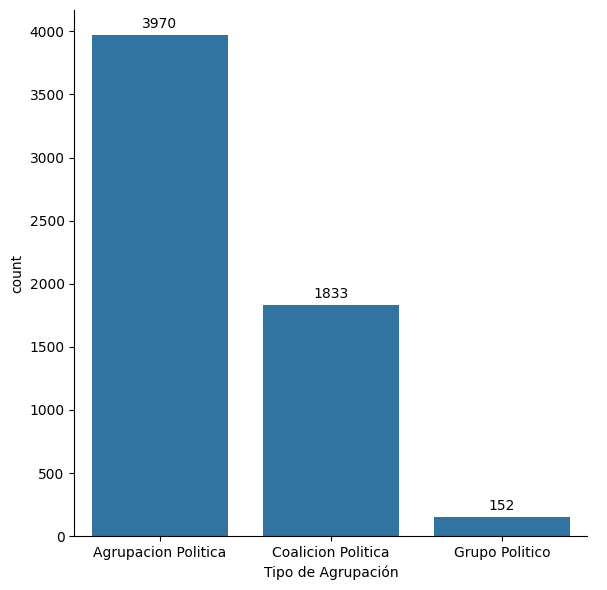

In [153]:
sns.catplot(
    x="Tipo de Agrupación",
    # col="Cargo",
    kind="count",
    height=6,
    aspect=1,
    data=df,
)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


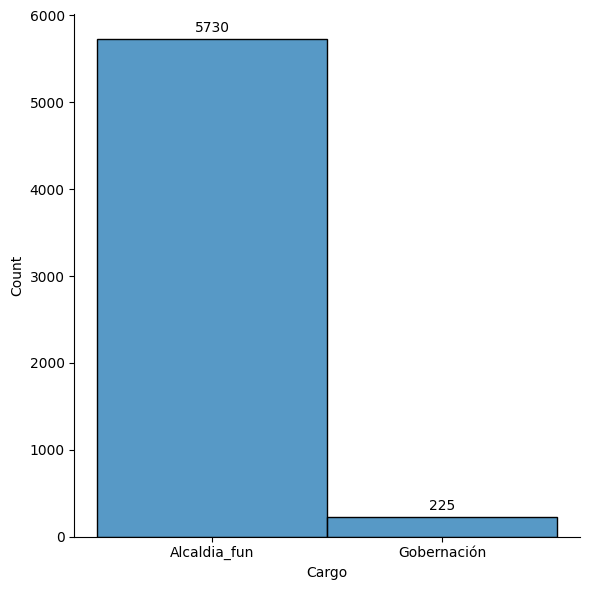

In [151]:
sns.displot(data=gastos_df, x="Cargo", height=6, aspect=1)
autoLabel()
plt.show()

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_7344\2759330335.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sum_gastos.values, y=sum_gastos.index, palette="viridis")


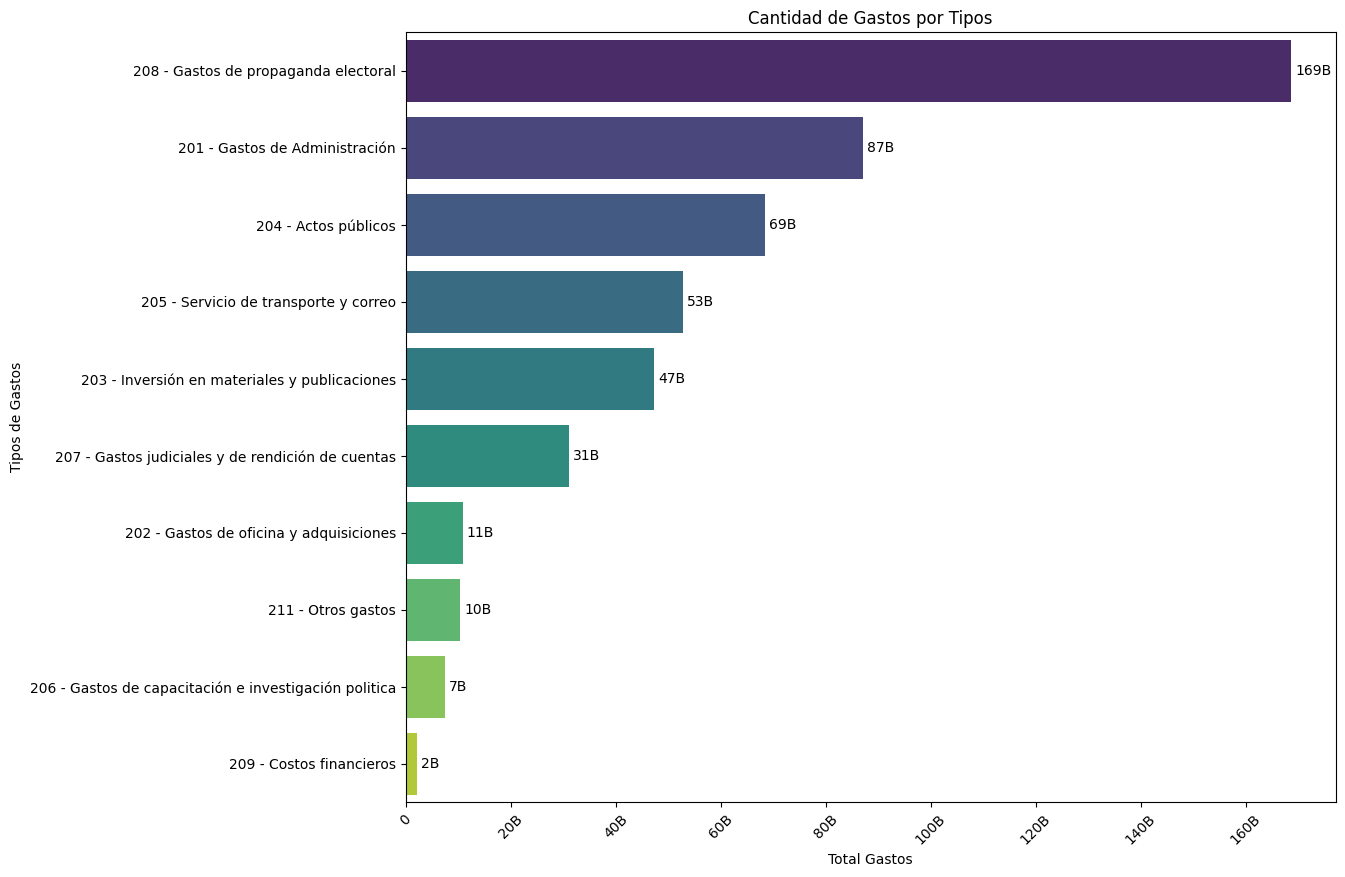

In [174]:
# Sumar los valores de cada tipo de gasto
sum_gastos = df[gasto_columns].sum()
sum_gastos = sum_gastos.sort_values(ascending=False)  # Ordenar de mayor a menor


# Crear la gráfica
plt.figure(figsize=(12, 10))
sns.barplot(x=sum_gastos.values, y=sum_gastos.index, palette="viridis")
plt.title("Cantidad de Gastos por Tipos")
plt.xlabel("Total Gastos")
plt.ylabel("Tipos de Gastos")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(func_form_millon_billon)
# plt.gca().yaxis.set_ticklabels(func_form_millon_billon)
autoLabelY()
plt.show()

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_7344\2956297197.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sum_ingresos.values, y=sum_ingresos.index, palette="viridis")


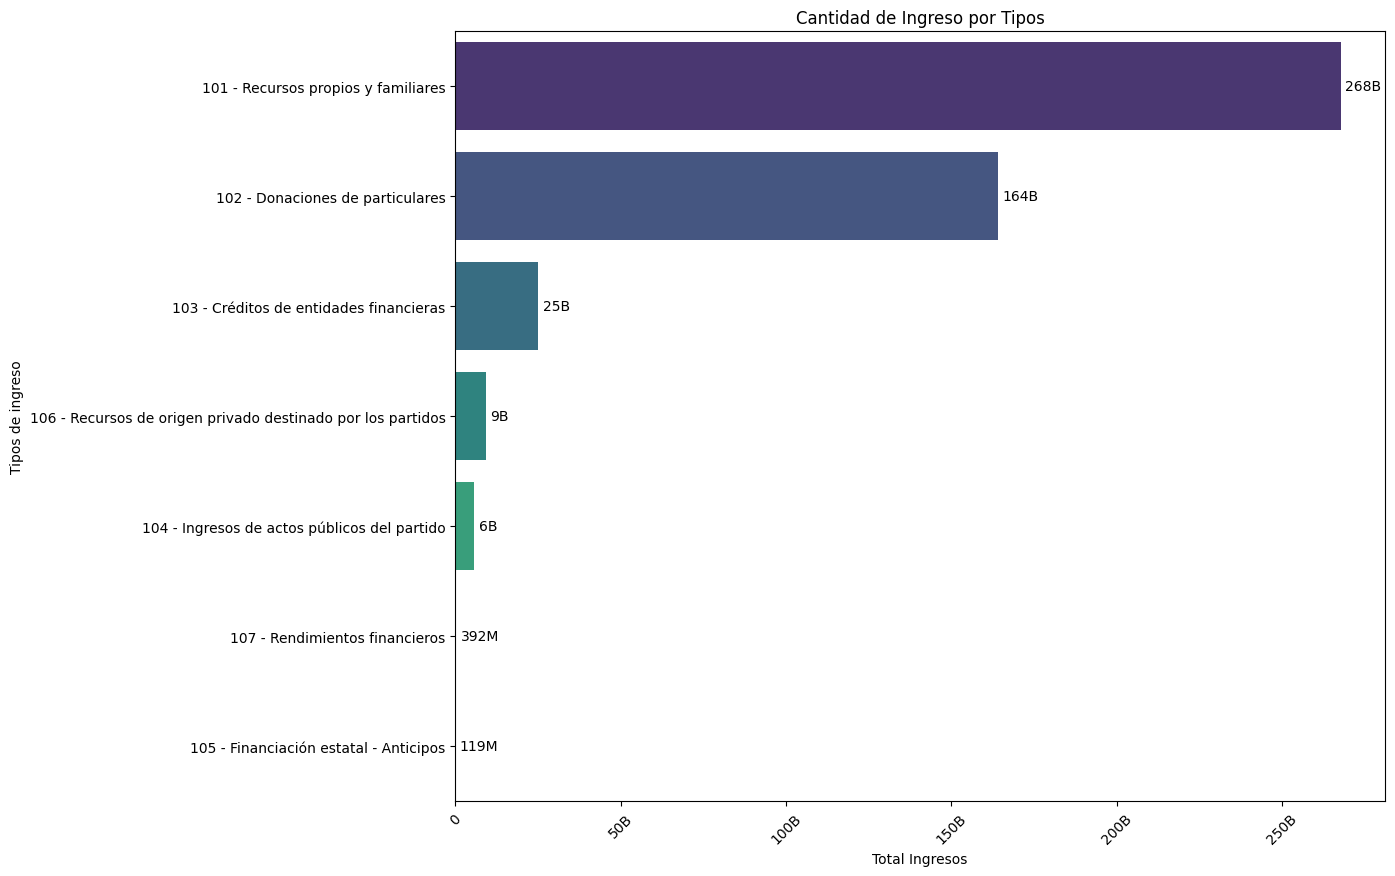

In [175]:
# Sumar los valores de cada tipo de gasto
sum_ingresos = df[ingresos_columns].sum()
sum_ingresos = sum_ingresos.sort_values(ascending=False)  # Ordenar de mayor a menor


# Crear la gráfica
plt.figure(figsize=(12, 10))
sns.barplot(x=sum_ingresos.values, y=sum_ingresos.index, palette="viridis")
plt.title("Cantidad de Ingreso por Tipos")
plt.xlabel("Total Ingresos")
plt.ylabel("Tipos de ingreso")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(func_form_millon_billon)
# plt.gca().yaxis.set_ticklabels(func_form_millon_billon)
autoLabelY()
plt.show()

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_7344\3037853071.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


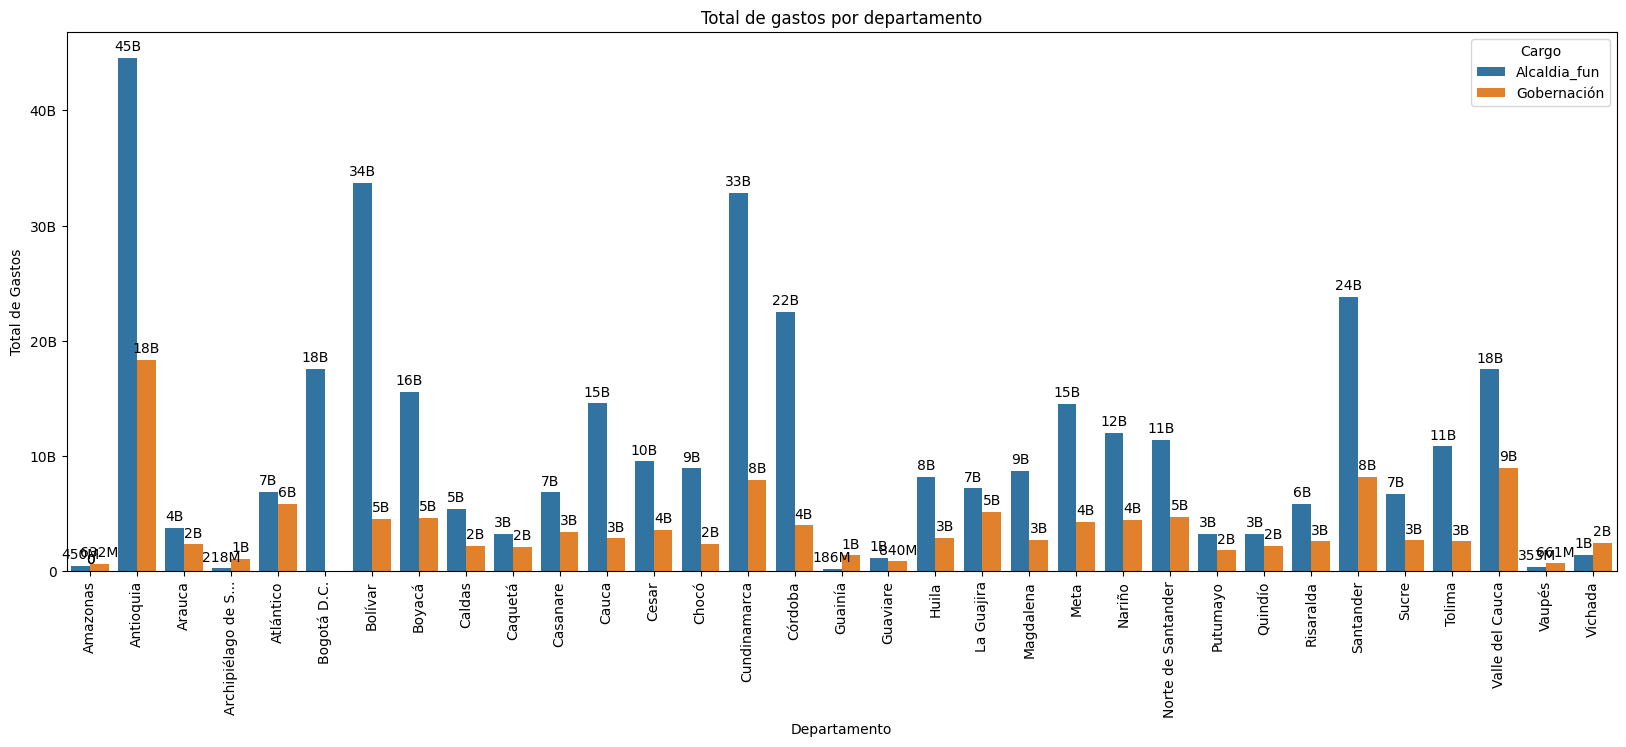

In [186]:
plt.figure(figsize=(20, 7))
sns.barplot(
    x="Departamento",
    y="Total de Gastos",
    hue="Cargo",
    # dodge=False,
    data=df.groupby(["Departamento", "Cargo"])["Total de Gastos"].sum().reset_index(),
    # aspect=2
)


plt.title("Total de gastos por departamento")
plt.xticks(rotation=90)

plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()

plt.show()